In [1]:
import torch
import multiModel as mm
from multiModel import MultiInputModel
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#Zapisz wyniki w 
path_results = "training_results_80_224_2"
# Utwórz katalog docelowy, jeśli nie istnieje
if not os.path.exists(path_results):
    print(f"Katalog '{path_results}' utworzony.")
    # Tworzenie katalogu, jeśli nie istnieje
    os.makedirs(path_results, exist_ok=True)

# Włącz blokowanie błędów CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Załaduj dane
train_dataset = mm.MultiInputDataset("CSV/dataset/train_80.csv", transform_rgb=mm.transform_rgb_224, transform_binary=mm.transform_binary_224)
val_dataset = mm.MultiInputDataset("CSV/dataset/val_80.csv", transform_rgb=mm.transform_rgb_224, transform_binary=mm.transform_binary_224)
test_dataset = mm.MultiInputDataset("CSV/dataset/test_80.csv", transform_rgb=mm.transform_rgb_224, transform_binary=mm.transform_binary_224)


# Inicjalizacja modelu
model = mm.CustomMultiInputModel(num_classes=11)
model = model.to("cuda")  # Jeśli masz GPU

#Dynamicznie przydzielany batch_size

batch_size = 64
model_name = "mm" + str(batch_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optymalizator i funkcja straty
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Zapis logów
log_file = f"{path_results}/training_log_{model_name}.txt"
with open(log_file, "w") as f:
    f.write("epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1\n")

# Wczesne zatrzymanie - parametry
early_stop_patience = 5  # Liczba epok bez poprawy
best_val_loss = float("inf")
patience_counter = 0
best_model_path = f"{path_results}/best_model_{model_name}.pth"

# Pętla treningowa
num_epochs = 50
for epoch in range(num_epochs):
    # === TRENING ===
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    train_loss = 0
    train_true = []
    train_pred = []

    # Dodaj pasek postępu do pętli batchy
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for t_image, b_image, s_image, labels in train_loader:
            t_image, b_image, s_image, labels = (
                t_image.to("cuda"),
                b_image.to("cuda"),
                s_image.to("cuda"),
                labels.to("cuda")
            )

            # Oblicz predykcje i stratę
            outputs = model(t_image, b_image, s_image)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())
            pbar.set_postfix({"loss": f"{train_loss / (pbar.n + 1):.4f}"})  # Wyświetl średnią stratę
            pbar.update(1)  # Aktualizuj pasek postępu o 1 krok

    train_loss /= len(train_loader)  # Średnia strata w treningu
    train_accuracy = accuracy_score(train_true, train_pred)
    train_precision = precision_score(train_true, train_pred, average="weighted")
    train_recall = recall_score(train_true, train_pred, average="weighted")
    train_f1 = f1_score(train_true, train_pred, average="weighted")
    #print(f"Train Loss: {train_loss:.4f}")

    # === WALIDACJA ===
    model.eval()
    val_loss = 0
    val_true = []
    val_pred = []

    with torch.no_grad():  # Wyłącz gradienty
        with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar_val:
            for t_image, b_image, s_image, labels in val_loader:
                t_image, b_image, s_image, labels = (
                    t_image.to("cuda"),
                    b_image.to("cuda"),
                    s_image.to("cuda"),
                    labels.to("cuda")
                )
                outputs = model(t_image, b_image, s_image)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                pbar_val.update(1)  # Aktualizuj pasek postępu walidacji

    val_loss /= len(val_loader)  # Średnia strata w walidacji
    val_accuracy = accuracy_score(val_true, val_pred)
    val_precision = precision_score(val_true, val_pred, average="weighted")
    val_recall = recall_score(val_true, val_pred, average="weighted")
    val_f1 = f1_score(val_true, val_pred, average="weighted")
    #print(f"Val Loss: {val_loss:.4f}")

    # === LOGI ===
    #print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    with open(log_file, "a") as f:
        f.write(
            f"{epoch + 1},{train_loss:.4f},{val_loss:.4f},{train_accuracy:.4f},{val_accuracy:.4f},"
            f"{train_precision:.4f},{val_precision:.4f},{train_recall:.4f},{val_recall:.4f},{train_f1:.4f},{val_f1:.4f}\n"
        )

    # === WCZESNE ZATRZYMANIE ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Zapis najlepszego modelu
        torch.save(model, best_model_path) #Zapisanie modelu i architektury w pliku pth
        print(f"Best model saved at epoch {epoch + 1}")
    else:
        patience_counter += 1
        print(f"No improvement in val loss for {patience_counter} epoch(s)")

    if patience_counter >= early_stop_patience:
        print("Early stopping triggered. Training stopped.")
        break
    


Katalog 'training_results_80_224_2' utworzony.
Epoch 1/50


Validation: 100%|██████████| 233/233 [00:49<00:00,  4.74batch/s]


Best model saved at epoch 1
Epoch 2/50


Validation: 100%|██████████| 233/233 [00:42<00:00,  5.43batch/s]


Best model saved at epoch 2
Epoch 3/50


Validation: 100%|██████████| 233/233 [00:43<00:00,  5.38batch/s]


Best model saved at epoch 3
Epoch 4/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.62batch/s]


Best model saved at epoch 4
Epoch 5/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.59batch/s]


Best model saved at epoch 5
Epoch 6/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.67batch/s]


Best model saved at epoch 6
Epoch 7/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.66batch/s]


Best model saved at epoch 7
Epoch 8/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.63batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 9/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.61batch/s]


Best model saved at epoch 9
Epoch 10/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.60batch/s]


Best model saved at epoch 10
Epoch 11/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.63batch/s]


Best model saved at epoch 11
Epoch 12/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.60batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 13/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.61batch/s]


Best model saved at epoch 13
Epoch 14/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.60batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 15/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.59batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 16/50


Validation: 100%|██████████| 233/233 [00:40<00:00,  5.72batch/s]


Best model saved at epoch 16
Epoch 17/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.59batch/s]


Best model saved at epoch 17
Epoch 18/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.61batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 19/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.58batch/s]


Best model saved at epoch 19
Epoch 20/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.62batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 21/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.60batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 22/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.61batch/s]


Best model saved at epoch 22
Epoch 23/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.61batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 24/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.63batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 25/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.60batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 26/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.59batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 27/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.67batch/s]


Best model saved at epoch 27
Epoch 28/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.56batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 29/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.68batch/s]


Best model saved at epoch 29
Epoch 30/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.63batch/s]


Best model saved at epoch 30
Epoch 31/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.62batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 32/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.65batch/s]


Best model saved at epoch 32
Epoch 33/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.64batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 34/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.64batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 35/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.59batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 36/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.64batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 37/50


Validation: 100%|██████████| 233/233 [00:41<00:00,  5.56batch/s]

No improvement in val loss for 5 epoch(s)
Early stopping triggered. Training stopped.


In [2]:
import torch
from multiModel import MultiInputModel, MultiInputDataset
import multiModel as mm
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm

# Set CUDA error blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Paths and parameters
path_results = "training_results_80_224_2"
model_name = "mm64"
best_model_path = f"{path_results}/best_model_{model_name}.pth"
test_csv = "CSV/dataset/test_80.csv"
batch_size = 64
num_classes = 11
class_names = [str(i) for i in range(num_classes)]  # Update with actual class names if available

# Create results directory if it doesn't exist
os.makedirs(path_results, exist_ok=True)

# Load test dataset
test_dataset = MultiInputDataset(test_csv, transform_rgb=mm.transform_rgb_224, transform_binary=mm.transform_binary_224)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the trained model
model = torch.load(best_model_path)
model = model.to("cuda")
model.eval()

# Loss function
criterion = nn.CrossEntropyLoss()

# Test loop
test_loss = 0
test_true = []
test_pred = []

with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
        for t_image, b_image, s_image, labels in test_loader:
            t_image, b_image, s_image, labels = (
                t_image.to("cuda"),
                b_image.to("cuda"),
                s_image.to("cuda"),
                labels.to("cuda")
            )
            outputs = model(t_image, b_image, s_image)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_true.extend(labels.cpu().numpy())
            test_pred.extend(predicted.cpu().numpy())
            pbar.update(1)

# Calculate metrics
test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_true, test_pred)
test_precision = precision_score(test_true, test_pred, average="weighted")
test_recall = recall_score(test_true, test_pred, average="weighted")
test_f1 = f1_score(test_true, test_pred, average="weighted")

# Log test metrics
test_log_file = f"{path_results}/test_results_{model_name}.txt"
with open(test_log_file, "w") as f:
    f.write("test_loss,test_accuracy,test_precision,test_recall,test_f1\n")
    f.write(f"{test_loss:.4f},{test_accuracy:.4f},{test_precision:.4f},{test_recall:.4f},{test_f1:.4f}\n")

# Compute confusion matrix
cm = confusion_matrix(test_true, test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

# Save confusion matrix plot
cm_plot_path = f"{path_results}/confusion_matrix_{model_name}.png"
plt.savefig(cm_plot_path)
plt.close()

print(f"Test results saved to {test_log_file}")
print(f"Confusion matrix saved to {cm_plot_path}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, "
      f"Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

/tmp/ipykernel_55378/4230748760.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(best_model_path)
Testing: 100%|██████████| 233/233 [01:06<00:00,  3.5

Test results saved to training_results_80_224_2/test_results_mm64.txt
Confusion matrix saved to training_results_80_224_2/confusion_matrix_mm64.png
Test Loss: 0.2039, Accuracy: 0.9367, Precision: 0.9383, Recall: 0.9367, F1: 0.9366


Twój skrypt jest już dobrze zorganizowany i zawiera kluczowe elementy do trenowania modelu klasyfikacji obrazów z różnymi rozmiarami partii (batch sizes) oraz logowaniem metryk klasyfikacyjnych. Jednak w kodzie znajduje się kilka problemów, takich jak błędna pętla modeli (for model), brak testowania na zbiorze testowym oraz brak podsumowania wyników dla wszystkich modeli. Poniżej przedstawiam poprawioną wersję skryptu, uwzględniając typowe podejście stosowane w analizie obrazu i klasyfikacji, w tym:

Trening z różnymi hiperparametrami: Iteracja po różnych rozmiarach partii (batch sizes).
Metryki klasyfikacyjne: Obliczanie dokładności, precyzji, czułości i F1 dla zbiorów treningowego, walidacyjnego i testowego.
Podsumowanie wyników: Generowanie raportu podsumowującego dla wszystkich modeli.
Optymalizacja: Uwzględnienie typowych praktyk, takich jak wczesne zatrzymanie, czyszczenie pamięci GPU i zapisywanie wyników.
Uwzględnienie najlepszych praktyk: Dodanie testowania na zbiorze testowym i zapis wyników w pliku CSV dla łatwiejszego porównania.
Kluczowe zmiany i ulepszenia:

Poprawiona pętla modeli: Usunięto błędną konstrukcję for model. Zamiast tego iterujemy po liście batch_size_list, co było intencją autora.
Dodanie zbioru testowego: Włączyłem zbiór testowy (test_dataset) i dodałem fazę testowania po zakończeniu treningu dla każdego modelu. Wyniki testowe są zapisywane w podsumowaniu.
Funkcja compute_metrics: Wprowadziłem funkcję do obliczania metryk klasyfikacyjnych, co poprawia czytelność i modularność kodu.
Podsumowanie wyników: Po zakończeniu treningu dla wszystkich modeli, wyniki (strata, dokładność, precyzja, czułość, F1) są zapisywane w pliku CSV (summary_results.csv) i wyświetlane w konsoli. Dodatkowo generowana jest wizualizacja zależności metryk od rozmiaru partii.
Zapis modelu: Zmieniono zapis modelu na torch.save(model.state_dict(), ...) zamiast zapisywania całego obiektu modelu, co jest bardziej standardową praktyką i pozwala na większą elastyczność przy wczytywaniu modelu.
Obsługa błędów w metrykach: Dodano parametr zero_division=0 w funkcjach precision_score, recall_score i f1_score, aby uniknąć błędów w przypadku klas bez predykcji.
Wizualizacja wyników: Dodano prostą wizualizację wyników testowych (dokładność i F1) w zależności od rozmiaru partii, zapisywaną jako plik PNG.

Typowe podejście w analizie obrazu:
Naukowcy w dziedzinie analizy obrazu często stosują następujące praktyki, które uwzględniłem w skrypcie:

Eksperymentowanie z hiperparametrami: Testowanie różnych rozmiarów partii, szybkości uczenia, architektur modelu itp.
Wczesne zatrzymanie: Monitorowanie straty walidacyjnej i zatrzymanie treningu, gdy model przestaje się poprawiać.
Logowanie i podsumowanie: Zapisywanie metryk (dokładność, precyzja, F1) dla każdego modelu i porównywanie ich w tabeli lub wizualizacji.
Testowanie na osobnym zbiorze: Ocena modelu na zbiorze testowym, aby uzyskać bezstronne oszacowanie wydajności.
Czyszczenie pamięci GPU: Ważne przy trenowaniu wielu modeli, aby uniknąć problemów z pamięcią.

Uwagi:

Dostosowanie hiperparametrów: Możesz rozszerzyć listę testowanych hiperparametrów (np. lr_list = [0.001, 0.0001]) i dodać zagnieżdżoną pętlę dla lr w podobny sposób jak dla batch_size.
Transformacje danych: Zakładam, że mm.transform_rgb_224 i mm.transform_binary_224 są odpowiednio zdefiniowane w module multiModel. Upewnij się, że transformacje są odpowiednie dla Twoich danych (np. normalizacja, augmentacja).
Zapis modelu: Jeśli chcesz zapisać pełny model (z architekturą), możesz wrócić do torch.save(model, ...) zamiast state_dict, ale pamiętaj o potencjalnych problemach z kompatybilnością.
Dodatkowe metryki: Możesz dodać inne metryki, takie jak ROC-AUC, jeśli są odpowiednie dla Twojego zadania.


=== Trening dla batch_size: 16 ===
Epoch 1/100


Validation: 100%|██████████| 931/931 [01:08<00:00, 13.61batch/s]


Best model saved at epoch 1
Epoch 2/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.37batch/s]


Best model saved at epoch 2
Epoch 3/100


Validation: 100%|██████████| 931/931 [01:01<00:00, 15.26batch/s]


Best model saved at epoch 3
Epoch 4/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.47batch/s]


Best model saved at epoch 4
Epoch 5/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.46batch/s]


Best model saved at epoch 5
Epoch 6/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.40batch/s]


Best model saved at epoch 6
Epoch 7/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.50batch/s]


Best model saved at epoch 7
Epoch 8/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.50batch/s]


Best model saved at epoch 8
Epoch 9/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.29batch/s]


Best model saved at epoch 9
Epoch 10/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.43batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 11/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.45batch/s]


Best model saved at epoch 11
Epoch 12/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.42batch/s]


Best model saved at epoch 12
Epoch 13/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.48batch/s]


Best model saved at epoch 13
Epoch 14/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.51batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 15/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.39batch/s]


Best model saved at epoch 15
Epoch 16/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.56batch/s]


Best model saved at epoch 16
Epoch 17/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.57batch/s]


Best model saved at epoch 17
Epoch 18/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.45batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 19/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.54batch/s]


Best model saved at epoch 19
Epoch 20/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.46batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 21/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.48batch/s]


Best model saved at epoch 21
Epoch 22/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.48batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 23/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.53batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 24/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.48batch/s]


Best model saved at epoch 24
Epoch 25/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.58batch/s]


Best model saved at epoch 25
Epoch 26/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.47batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 27/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.42batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 28/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.50batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 29/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.53batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 30/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.50batch/s]


Best model saved at epoch 30
Epoch 31/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.58batch/s]


Best model saved at epoch 31
Epoch 32/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.45batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 33/100


Validation: 100%|██████████| 931/931 [01:02<00:00, 14.83batch/s]


Best model saved at epoch 33
Epoch 34/100


Validation: 100%|██████████| 931/931 [01:02<00:00, 14.81batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 35/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.47batch/s]


Best model saved at epoch 35
Epoch 36/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.52batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 37/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.65batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 38/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.59batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 39/100


Validation: 100%|██████████| 931/931 [01:05<00:00, 14.19batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 40/100


Validation: 100%|██████████| 931/931 [01:02<00:00, 14.83batch/s]


Best model saved at epoch 40
Epoch 41/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.49batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 42/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.42batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 43/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.51batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 44/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.53batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 45/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.47batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 46/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.51batch/s]


Best model saved at epoch 46
Epoch 47/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.63batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 48/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.39batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 49/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.60batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 50/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.56batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 51/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.54batch/s]


Best model saved at epoch 51
Epoch 52/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.64batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 53/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.66batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 54/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.52batch/s]


Best model saved at epoch 54
Epoch 55/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.56batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 56/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.66batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 57/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.56batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 58/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.56batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 59/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.57batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 60/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.58batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 61/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.52batch/s]


No improvement in val loss for 7 epoch(s)
Epoch 62/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.54batch/s]


No improvement in val loss for 8 epoch(s)
Epoch 63/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.57batch/s]


Best model saved at epoch 63
Epoch 64/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.56batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 65/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.61batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 66/100


Validation: 100%|██████████| 931/931 [01:00<00:00, 15.50batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 67/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.60batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 68/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.55batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 69/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.61batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 70/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.72batch/s]


No improvement in val loss for 7 epoch(s)
Epoch 71/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.58batch/s]


No improvement in val loss for 8 epoch(s)
Epoch 72/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.53batch/s]


No improvement in val loss for 9 epoch(s)
Epoch 73/100


Validation: 100%|██████████| 931/931 [00:59<00:00, 15.58batch/s]
/tmp/ipykernel_69104/673473184.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

No improvement in val loss for 10 epoch(s)
Early stopping triggered. Training stopped.

=== Testowanie modelu dla batch_size: 16 ===


Testing: 100%|██████████| 931/931 [01:03<00:00, 14.75batch/s]



=== Trening dla batch_size: 32 ===
Epoch 1/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.97batch/s]


Best model saved at epoch 1
Epoch 2/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.97batch/s]


Best model saved at epoch 2
Epoch 3/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.96batch/s]


Best model saved at epoch 3
Epoch 4/100


Validation: 100%|██████████| 466/466 [00:59<00:00,  7.85batch/s]


Best model saved at epoch 4
Epoch 5/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.92batch/s]


Best model saved at epoch 5
Epoch 6/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.97batch/s]


Best model saved at epoch 6
Epoch 7/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.94batch/s]


Best model saved at epoch 7
Epoch 8/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.92batch/s]


Best model saved at epoch 8
Epoch 9/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  8.02batch/s]


Best model saved at epoch 9
Epoch 10/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.95batch/s]


Best model saved at epoch 10
Epoch 11/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.91batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 12/100


Validation: 100%|██████████| 466/466 [00:56<00:00,  8.22batch/s]


Best model saved at epoch 12
Epoch 13/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.94batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 14/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.96batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 15/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  8.00batch/s]


Best model saved at epoch 15
Epoch 16/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.92batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 17/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.96batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 18/100


Validation: 100%|██████████| 466/466 [00:57<00:00,  8.17batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 19/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.92batch/s]


Best model saved at epoch 19
Epoch 20/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.96batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 21/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.93batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 22/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.99batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 23/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.96batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 24/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.91batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 25/100


Validation: 100%|██████████| 466/466 [00:59<00:00,  7.89batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 26/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.93batch/s]


No improvement in val loss for 7 epoch(s)
Epoch 27/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.91batch/s]


Best model saved at epoch 27
Epoch 28/100


Validation: 100%|██████████| 466/466 [00:59<00:00,  7.90batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 29/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.98batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 30/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.97batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 31/100


Validation: 100%|██████████| 466/466 [00:59<00:00,  7.88batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 32/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.94batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 33/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.96batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 34/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.91batch/s]


No improvement in val loss for 7 epoch(s)
Epoch 35/100


Validation: 100%|██████████| 466/466 [00:59<00:00,  7.90batch/s]


No improvement in val loss for 8 epoch(s)
Epoch 36/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  8.01batch/s]


No improvement in val loss for 9 epoch(s)
Epoch 37/100


Validation: 100%|██████████| 466/466 [00:58<00:00,  7.97batch/s]
/tmp/ipykernel_69104/673473184.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

No improvement in val loss for 10 epoch(s)
Early stopping triggered. Training stopped.

=== Testowanie modelu dla batch_size: 32 ===


Testing: 100%|██████████| 466/466 [00:58<00:00,  7.91batch/s]



=== Trening dla batch_size: 64 ===
Epoch 1/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.23batch/s]


Best model saved at epoch 1
Epoch 2/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


Best model saved at epoch 2
Epoch 3/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


Best model saved at epoch 3
Epoch 4/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.22batch/s]


Best model saved at epoch 4
Epoch 5/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


Best model saved at epoch 5
Epoch 6/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.18batch/s]


Best model saved at epoch 6
Epoch 7/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.22batch/s]


Best model saved at epoch 7
Epoch 8/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


Best model saved at epoch 8
Epoch 9/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.18batch/s]


Best model saved at epoch 9
Epoch 10/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


Best model saved at epoch 10
Epoch 11/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 12/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.22batch/s]


Best model saved at epoch 12
Epoch 13/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 14/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


Best model saved at epoch 14
Epoch 15/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 16/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


Best model saved at epoch 16
Epoch 17/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.18batch/s]


Best model saved at epoch 17
Epoch 18/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


Best model saved at epoch 18
Epoch 19/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 20/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 21/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


Best model saved at epoch 21
Epoch 22/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 23/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 24/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.23batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 25/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.22batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 26/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.18batch/s]


Best model saved at epoch 26
Epoch 27/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.23batch/s]


Best model saved at epoch 27
Epoch 28/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 29/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.22batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 30/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.18batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 31/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 32/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.18batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 33/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 34/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


Best model saved at epoch 34
Epoch 35/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


Best model saved at epoch 35
Epoch 36/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


Best model saved at epoch 36
Epoch 37/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 38/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


Best model saved at epoch 38
Epoch 39/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


Best model saved at epoch 39
Epoch 40/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.18batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 41/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.17batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 42/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 43/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 44/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 45/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 46/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.20batch/s]


No improvement in val loss for 7 epoch(s)
Epoch 47/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]


No improvement in val loss for 8 epoch(s)
Epoch 48/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.17batch/s]


No improvement in val loss for 9 epoch(s)
Epoch 49/100


Validation: 100%|██████████| 233/233 [00:55<00:00,  4.19batch/s]
/tmp/ipykernel_69104/673473184.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

No improvement in val loss for 10 epoch(s)
Early stopping triggered. Training stopped.

=== Testowanie modelu dla batch_size: 64 ===


Testing: 100%|██████████| 233/233 [00:55<00:00,  4.21batch/s]



=== Trening dla batch_size: 128 ===
Epoch 1/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


Best model saved at epoch 1
Epoch 2/100


Validation: 100%|██████████| 117/117 [00:54<00:00,  2.13batch/s]


Best model saved at epoch 2
Epoch 3/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.09batch/s]


Best model saved at epoch 3
Epoch 4/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


Best model saved at epoch 4
Epoch 5/100


Validation: 100%|██████████| 117/117 [00:54<00:00,  2.13batch/s]


Best model saved at epoch 5
Epoch 6/100


Validation: 100%|██████████| 117/117 [00:54<00:00,  2.14batch/s]


Best model saved at epoch 6
Epoch 7/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


Best model saved at epoch 7
Epoch 8/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 8
Epoch 9/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 9
Epoch 10/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 11/100


Validation: 100%|██████████| 117/117 [00:54<00:00,  2.14batch/s]


Best model saved at epoch 11
Epoch 12/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.13batch/s]


Best model saved at epoch 12
Epoch 13/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


Best model saved at epoch 13
Epoch 14/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


Best model saved at epoch 14
Epoch 15/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 16/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 16
Epoch 17/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


Best model saved at epoch 17
Epoch 18/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 19/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.09batch/s]


Best model saved at epoch 19
Epoch 20/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 21/100


Validation: 100%|██████████| 117/117 [00:54<00:00,  2.14batch/s]


Best model saved at epoch 21
Epoch 22/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


Best model saved at epoch 22
Epoch 23/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.09batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 24/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 25/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 26/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 27/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 27
Epoch 28/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


Best model saved at epoch 28
Epoch 29/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.11batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 30/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 31/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 32/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 33/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 34/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.11batch/s]


Best model saved at epoch 34
Epoch 35/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 35
Epoch 36/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.09batch/s]


Best model saved at epoch 36
Epoch 37/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.09batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 38/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 38
Epoch 39/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 40/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.09batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 41/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 42/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 43/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 44/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 44
Epoch 45/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 46/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 47/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 48/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.11batch/s]


Best model saved at epoch 48
Epoch 49/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 50/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 50
Epoch 51/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


Best model saved at epoch 51
Epoch 52/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 53/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.09batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 54/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 55/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 56/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 57/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


Best model saved at epoch 57
Epoch 58/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 59/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 60/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 61/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 62/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 63/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.05batch/s]


Best model saved at epoch 63
Epoch 64/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.12batch/s]


Best model saved at epoch 64
Epoch 65/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 66/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.09batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 67/100


Validation: 100%|██████████| 117/117 [00:54<00:00,  2.13batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 68/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 69/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 70/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.09batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 71/100


Validation: 100%|██████████| 117/117 [00:57<00:00,  2.05batch/s]


No improvement in val loss for 7 epoch(s)
Epoch 72/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 8 epoch(s)
Epoch 73/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 9 epoch(s)
Epoch 74/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


Best model saved at epoch 74
Epoch 75/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 76/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 77/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 78/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 79/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 80/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 81/100


Validation: 100%|██████████| 117/117 [00:55<00:00,  2.10batch/s]


No improvement in val loss for 7 epoch(s)
Epoch 82/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.06batch/s]


No improvement in val loss for 8 epoch(s)
Epoch 83/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.08batch/s]


No improvement in val loss for 9 epoch(s)
Epoch 84/100


Validation: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]
/tmp/ipykernel_69104/673473184.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t

No improvement in val loss for 10 epoch(s)
Early stopping triggered. Training stopped.

=== Testowanie modelu dla batch_size: 128 ===


Testing: 100%|██████████| 117/117 [00:56<00:00,  2.07batch/s]



=== Trening dla batch_size: 256 ===
Epoch 1/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 1
Epoch 2/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 2
Epoch 3/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 3
Epoch 4/100


Validation: 100%|██████████| 59/59 [00:53<00:00,  1.11batch/s]


Best model saved at epoch 4
Epoch 5/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 5
Epoch 6/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 6
Epoch 7/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 7
Epoch 8/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 8
Epoch 9/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 9
Epoch 10/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 10
Epoch 11/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 12/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


Best model saved at epoch 12
Epoch 13/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 14/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.05batch/s]


Best model saved at epoch 14
Epoch 15/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 15
Epoch 16/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 16
Epoch 17/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 18/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 18
Epoch 19/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 19
Epoch 20/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 21/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 21
Epoch 22/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 23/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


Best model saved at epoch 23
Epoch 24/100


Validation: 100%|██████████| 59/59 [00:53<00:00,  1.11batch/s]


Best model saved at epoch 24
Epoch 25/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 26/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 26
Epoch 27/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 27
Epoch 28/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.04batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 29/100


Validation: 100%|██████████| 59/59 [00:53<00:00,  1.10batch/s]


Best model saved at epoch 29
Epoch 30/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 31/100


Validation: 100%|██████████| 59/59 [00:53<00:00,  1.10batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 32/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 32
Epoch 33/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 34/100


Validation: 100%|██████████| 59/59 [00:53<00:00,  1.11batch/s]


Best model saved at epoch 34
Epoch 35/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 36/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 36
Epoch 37/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 38/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 39/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 40/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 40
Epoch 41/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 42/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 43/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 44/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 45/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 45
Epoch 46/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 47/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 47
Epoch 48/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 49/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 50/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 50
Epoch 51/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 51
Epoch 52/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 53/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 54/100


Validation: 100%|██████████| 59/59 [00:59<00:00,  1.01s/batch]


Best model saved at epoch 54
Epoch 55/100


Validation: 100%|██████████| 59/59 [00:59<00:00,  1.01s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 56/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 57/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 58/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 59/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 60/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 60
Epoch 61/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.07batch/s]


Best model saved at epoch 61
Epoch 62/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


Best model saved at epoch 62
Epoch 63/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


Best model saved at epoch 63
Epoch 64/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.09batch/s]


Best model saved at epoch 64
Epoch 65/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 65
Epoch 66/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 67/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 68/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 69/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 70/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 71/100


Validation: 100%|██████████| 59/59 [00:52<00:00,  1.11batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 72/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 72
Epoch 73/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 74/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 75/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.05batch/s]


Best model saved at epoch 75
Epoch 76/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 77/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 78/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 79/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.05batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 80/100


Validation: 100%|██████████| 59/59 [00:53<00:00,  1.11batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 81/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.05batch/s]


Best model saved at epoch 81
Epoch 82/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 83/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.07batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 84/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 84
Epoch 85/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


Best model saved at epoch 85
Epoch 86/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 87/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 88/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 89/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 90/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 91/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 92/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


Best model saved at epoch 92
Epoch 93/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.07batch/s]


Best model saved at epoch 93
Epoch 94/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 1 epoch(s)
Epoch 95/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 2 epoch(s)
Epoch 96/100


Validation: 100%|██████████| 59/59 [00:54<00:00,  1.08batch/s]


No improvement in val loss for 3 epoch(s)
Epoch 97/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.07batch/s]


No improvement in val loss for 4 epoch(s)
Epoch 98/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]


No improvement in val loss for 5 epoch(s)
Epoch 99/100


Validation: 100%|██████████| 59/59 [00:56<00:00,  1.05batch/s]


No improvement in val loss for 6 epoch(s)
Epoch 100/100


Validation: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]
/tmp/ipykernel_69104/673473184.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(tor

No improvement in val loss for 7 epoch(s)

=== Testowanie modelu dla batch_size: 256 ===


Testing: 100%|██████████| 59/59 [00:55<00:00,  1.06batch/s]



=== Trening dla batch_size: 512 ===
Epoch 1/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


Best model saved at epoch 1
Epoch 2/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 2
Epoch 3/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 3
Epoch 4/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.83s/batch]


Best model saved at epoch 4
Epoch 5/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


Best model saved at epoch 5
Epoch 6/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 6
Epoch 7/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


Best model saved at epoch 7
Epoch 8/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 8
Epoch 9/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


Best model saved at epoch 9
Epoch 10/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 10
Epoch 11/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 11
Epoch 12/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.80s/batch]


Best model saved at epoch 12
Epoch 13/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 13
Epoch 14/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 14
Epoch 15/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 16/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.80s/batch]


Best model saved at epoch 16
Epoch 17/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 17
Epoch 18/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


Best model saved at epoch 18
Epoch 19/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 20/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


Best model saved at epoch 20
Epoch 21/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


Best model saved at epoch 21
Epoch 22/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 22
Epoch 23/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 23
Epoch 24/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 25/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.81s/batch]


Best model saved at epoch 25
Epoch 26/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 27/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 27
Epoch 28/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 29/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


Best model saved at epoch 29
Epoch 30/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 30
Epoch 31/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.80s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 32/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 32
Epoch 33/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.80s/batch]


Best model saved at epoch 33
Epoch 34/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 35/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 35
Epoch 36/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.86s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 37/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


Best model saved at epoch 37
Epoch 38/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.80s/batch]


Best model saved at epoch 38
Epoch 39/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 40/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 41/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 41
Epoch 42/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


Best model saved at epoch 42
Epoch 43/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 44/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 45/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.86s/batch]


No improvement in val loss for 3 epoch(s)
Epoch 46/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 4 epoch(s)
Epoch 47/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 5 epoch(s)
Epoch 48/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 48
Epoch 49/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 50/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 51/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 51
Epoch 52/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 53/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 54/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.79s/batch]


No improvement in val loss for 3 epoch(s)
Epoch 55/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.77s/batch]


No improvement in val loss for 4 epoch(s)
Epoch 56/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.78s/batch]


No improvement in val loss for 5 epoch(s)
Epoch 57/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 57
Epoch 58/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 59/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.80s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 60/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.81s/batch]


No improvement in val loss for 3 epoch(s)
Epoch 61/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 61
Epoch 62/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


Best model saved at epoch 62
Epoch 63/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 64/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.79s/batch]


Best model saved at epoch 64
Epoch 65/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 66/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 66
Epoch 67/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 67
Epoch 68/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 69/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.86s/batch]


Best model saved at epoch 69
Epoch 70/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.80s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 71/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 72/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 3 epoch(s)
Epoch 73/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.86s/batch]


Best model saved at epoch 73
Epoch 74/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 75/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.86s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 76/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 3 epoch(s)
Epoch 77/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 4 epoch(s)
Epoch 78/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 5 epoch(s)
Epoch 79/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 6 epoch(s)
Epoch 80/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 80
Epoch 81/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 82/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 82
Epoch 83/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 84/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.78s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 85/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


Best model saved at epoch 85
Epoch 86/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.80s/batch]


Best model saved at epoch 86
Epoch 87/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 88/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.82s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 89/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 3 epoch(s)
Epoch 90/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.86s/batch]


No improvement in val loss for 4 epoch(s)
Epoch 91/100


Validation: 100%|██████████| 30/30 [00:53<00:00,  1.78s/batch]


No improvement in val loss for 5 epoch(s)
Epoch 92/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 92
Epoch 93/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.81s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 94/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


No improvement in val loss for 2 epoch(s)
Epoch 95/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]


No improvement in val loss for 3 epoch(s)
Epoch 96/100


Validation: 100%|██████████| 30/30 [00:54<00:00,  1.83s/batch]


Best model saved at epoch 96
Epoch 97/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


Best model saved at epoch 97
Epoch 98/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]


Best model saved at epoch 98
Epoch 99/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.83s/batch]


No improvement in val loss for 1 epoch(s)
Epoch 100/100


Validation: 100%|██████████| 30/30 [00:55<00:00,  1.85s/batch]
/tmp/ipykernel_69104/673473184.py:153: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(tor

No improvement in val loss for 2 epoch(s)

=== Testowanie modelu dla batch_size: 512 ===


Testing: 100%|██████████| 30/30 [00:55<00:00,  1.84s/batch]



=== Podsumowanie wyników ===
   batch_size  best_val_loss  test_loss  test_accuracy  test_precision  \
0          16       0.230348   0.226880       0.927708        0.929008   
1          32       0.302749   0.284446       0.908761        0.912640   
2          64       0.253714   0.257643       0.918369        0.919912   
3         128       0.231033   0.224408       0.928581        0.930764   
4         256       0.229286   0.200512       0.937517        0.939148   
5         512       0.396481   0.358165       0.883633        0.889193   

   test_recall   test_f1  
0     0.927708  0.927787  
1     0.908761  0.908892  
2     0.918369  0.918217  
3     0.928581  0.928422  
4     0.937517  0.937578  
5     0.883633  0.882133  


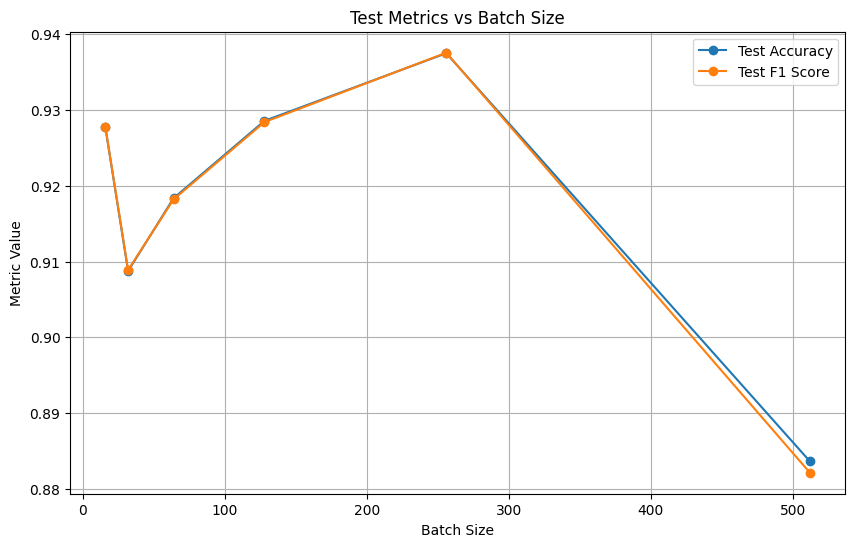

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import pandas as pd
import multiModel as mm
from multiModel import MultiInputModel

# Ustawienia
path_results = "training_results_80_224_3"
if not os.path.exists(path_results):
    print(f"Katalog '{path_results}' utworzony.")
    os.makedirs(path_results, exist_ok=True)

# Włącz blokowanie błędów CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Załaduj dane
train_dataset = mm.MultiInputDataset("CSV/dataset/train_80.csv", transform_rgb=mm.train_transform_rgb_80, transform_binary=mm.transform_binary_80)
val_dataset = mm.MultiInputDataset("CSV/dataset/val_80.csv", transform_rgb=mm.val_transform_rgb_80, transform_binary=mm.transform_binary_80)
test_dataset = mm.MultiInputDataset("CSV/dataset/test_80.csv", transform_rgb=mm.val_transform_rgb_80, transform_binary=mm.transform_binary_80)

# Lista hiperparametrów do przetestowania
batch_size_list = [16, 32, 64, 128, 256, 512]
results_summary = []

# Funkcja do obliczania metryk
def compute_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average="weighted", zero_division=0)
    recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)
    return accuracy, precision, recall, f1

# Pętla po różnych batch_size
for batch_size in batch_size_list:
    print(f"\n=== Trening dla batch_size: {batch_size} ===")
    
    # Inicjalizacja DataLoaderów
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Inicjalizacja modelu
    model = mm.CustomMultiInputModel(num_classes=11).to("cuda")
    model_name = f"mm_batch_{batch_size}"

    # Optymalizator i funkcja straty
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Logi treningowe
    log_file = f"{path_results}/training_log_{model_name}.txt"
    with open(log_file, "w") as f:
        f.write("epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1\n")

    # Wczesne zatrzymanie
    early_stop_patience = 10
    best_val_loss = float("inf")
    patience_counter = 0
    best_model_path = f"{path_results}/best_model_{model_name}.pth"

    # Pętla treningowa
    num_epochs = 100
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        # === TRENING ===
        model.train()
        train_loss = 0
        train_true, train_pred = [], []

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for t_image, b_image, s_image, labels in train_loader:
                t_image, b_image, s_image, labels = (
                    t_image.to("cuda"),
                    b_image.to("cuda"),
                    s_image.to("cuda"),
                    labels.to("cuda")
                )

                # Oblicz predykcje i stratę
                outputs = model(t_image, b_image, s_image)
                loss = criterion(outputs, labels)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_true.extend(labels.cpu().numpy())
                train_pred.extend(predicted.cpu().numpy())
                pbar.set_postfix({"loss": f"{train_loss / (pbar.n + 1):.4f}"})
                pbar.update(1)

        train_loss /= len(train_loader)
        train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(train_true, train_pred)

        # === WALIDACJA ===
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []

        with torch.no_grad():
            with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar_val:
                for t_image, b_image, s_image, labels in val_loader:
                    t_image, b_image, s_image, labels = (
                        t_image.to("cuda"),
                        b_image.to("cuda"),
                        s_image.to("cuda"),
                        labels.to("cuda")
                    )
                    outputs = model(t_image, b_image, s_image)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    val_true.extend(labels.cpu().numpy())
                    val_pred.extend(predicted.cpu().numpy())
                    pbar_val.update(1)

        val_loss /= len(val_loader)
        val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(val_true, val_pred)

        # Zapis logów
        with open(log_file, "a") as f:
            f.write(
                f"{epoch + 1},{train_loss:.4f},{val_loss:.4f},{train_accuracy:.4f},{val_accuracy:.4f},"
                f"{train_precision:.4f},{val_precision:.4f},{train_recall:.4f},{val_recall:.4f},{train_f1:.4f},{val_f1:.4f}\n"
            )

        # Wczesne zatrzymanie
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch + 1}")
        else:
            patience_counter += 1
            print(f"No improvement in val loss for {patience_counter} epoch(s)")

        if patience_counter >= early_stop_patience:
            print("Early stopping triggered. Training stopped.")
            break

    # === TESTOWANIE ===
    print(f"\n=== Testowanie modelu dla batch_size: {batch_size} ===")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    test_loss = 0
    test_true, test_pred = [], []

    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar_test:
            for t_image, b_image, s_image, labels in test_loader:
                t_image, b_image, s_image, labels = (
                    t_image.to("cuda"),
                    b_image.to("cuda"),
                    s_image.to("cuda"),
                    labels.to("cuda")
                )
                outputs = model(t_image, b_image, s_image)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                test_true.extend(labels.cpu().numpy())
                test_pred.extend(predicted.cpu().numpy())
                pbar_test.update(1)

    test_loss /= len(test_loader)
    test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(test_true, test_pred)

    # Zapis wyników do podsumowania
    results_summary.append({
        "batch_size": batch_size,
        "best_val_loss": best_val_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1": test_f1
    })

    # Czyszczenie pamięci
    del model
    torch.cuda.empty_cache()

# === PODSUMOWANIE WYNIKÓW ===
summary_df = pd.DataFrame(results_summary)
summary_df.to_csv(f"{path_results}/summary_results.csv", index=False)
print("\n=== Podsumowanie wyników ===")
print(summary_df)

# Opcjonalnie: wizualizacja wyników
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(summary_df["batch_size"], summary_df["test_accuracy"], marker='o', label="Test Accuracy")
plt.plot(summary_df["batch_size"], summary_df["test_f1"], marker='o', label="Test F1 Score")
plt.xlabel("Batch Size")
plt.ylabel("Metric Value")
plt.title("Test Metrics vs Batch Size")
plt.legend()
plt.grid(True)
plt.savefig(f"{path_results}/metrics_plot.png")
plt.show()